In [ ]:
# Cell 1: Install requirements
!pip install pandas numpy scikit-learn imbalanced-learn matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 2: Setup project structure
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/
!mkdir -p diabetes-ml-project/{notebooks,data/raw,data/processed,src,models}
%cd diabetes-ml-project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive/diabetes-ml-project


In [ ]:
# Cell 3: Download dataset directly from Kaggle
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload your kaggle.json API key when prompted

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d uciml/pima-indians-diabetes-database
!unzip pima-indians-diabetes-database.zip -d data/raw/

Saving diabetes.csv to diabetes (2).csv
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open pima-indians-diabetes-database.zip, pima-indians-diabetes-database.zip.zip or pima-india

Dataset shape: (768, 9)

Missing values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Data types:
 Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Class distribution:
 Outcome
0    500
1    268
Name: count, dtype: int64


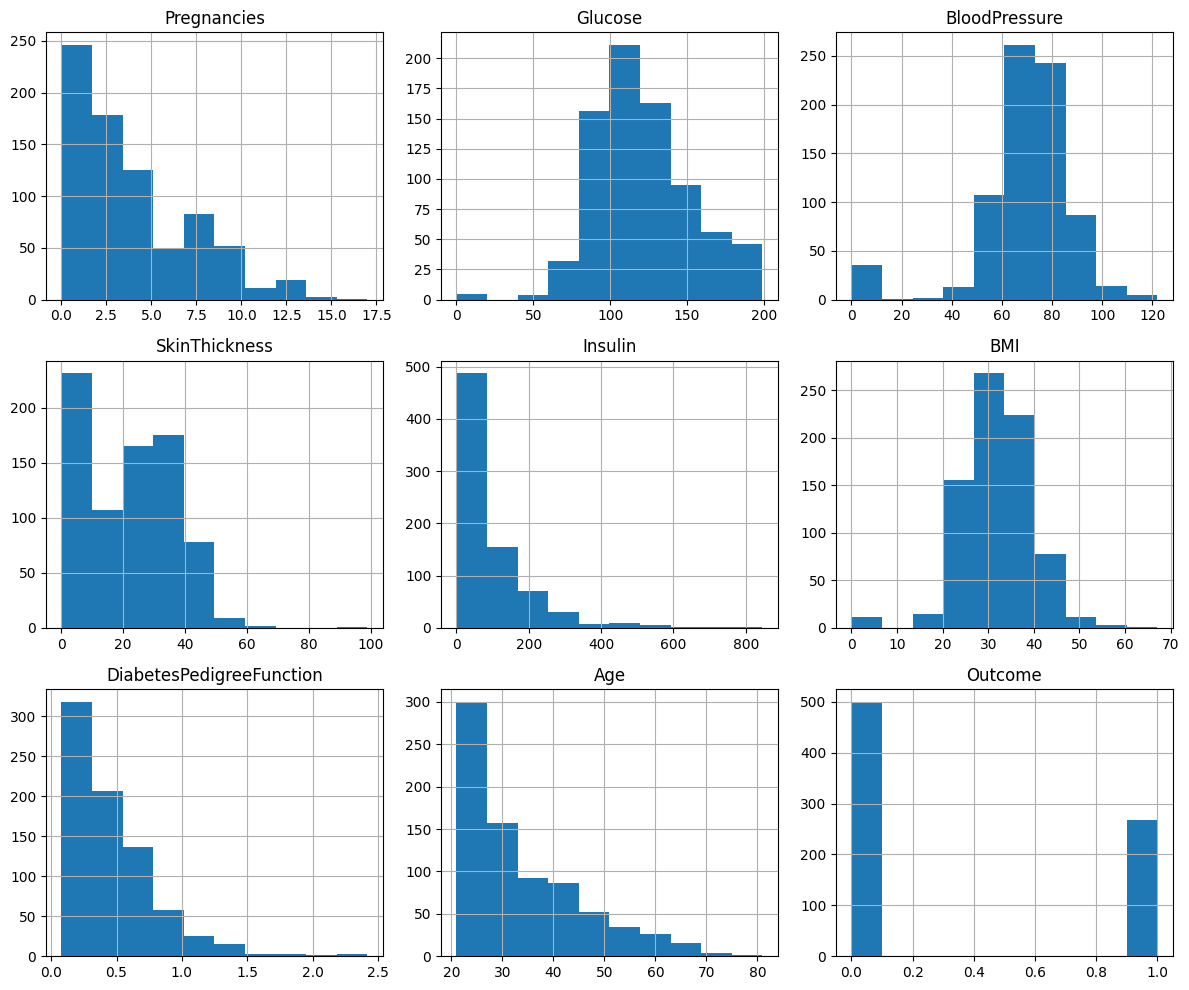

In [ ]:
# Cell 4: Data exploration
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("data/raw/diabetes.csv")

# Basic info
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
print("\nClass distribution:\n", df['Outcome'].value_counts())

# Visualize distributions
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.savefig('data/processed/initial_distributions.png')
plt.show()

In [ ]:
# Cell 5: Preprocessing
from sklearn.model_selection import train_test_split

# Handle zero values
cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols] = df[cols].replace(0, pd.NA)
df = df.dropna()

# Split data
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Save processed data
X_train.to_csv("data/processed/X_train.csv", index=False)
X_test.to_csv("data/processed/X_test.csv", index=False)
y_train.to_csv("data/processed/y_train.csv", index=False)
y_test.to_csv("data/processed/y_test.csv", index=False)

print("Preprocessing complete!")
print(f"Train size: {X_train.shape[0]} samples")
print(f"Test size: {X_test.shape[0]} samples")

Preprocessing complete!
Train size: 313 samples
Test size: 79 samples


In [ ]:
# Cell 6: Install ML libraries
!pip install xgboost imbalanced-learn seaborn

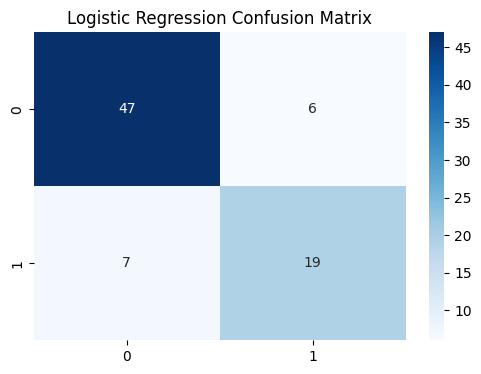

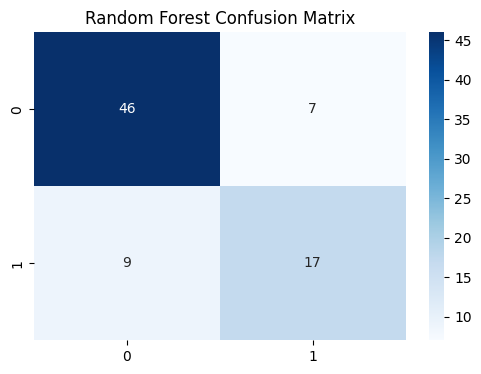

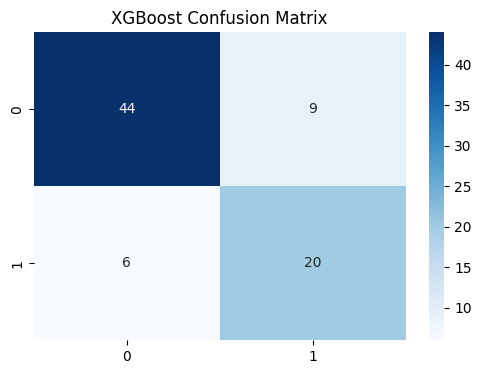

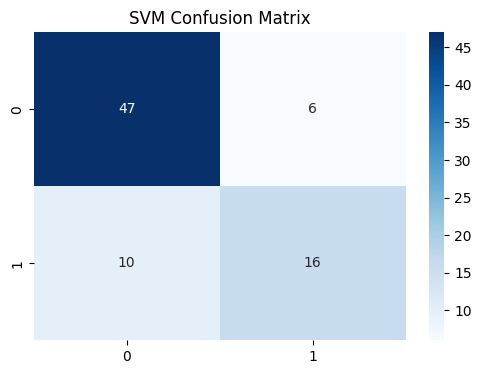


Model Performance Comparison:


,Model,Accuracy,F1 Score,ROC AUC
0,Logistic Regression,0.835443,0.745098,0.887518
1,Random Forest,0.797468,0.680000,0.862845
2,XGBoost,0.810127,0.727273,0.825109
3,SVM,0.797468,0.666667,0.849782


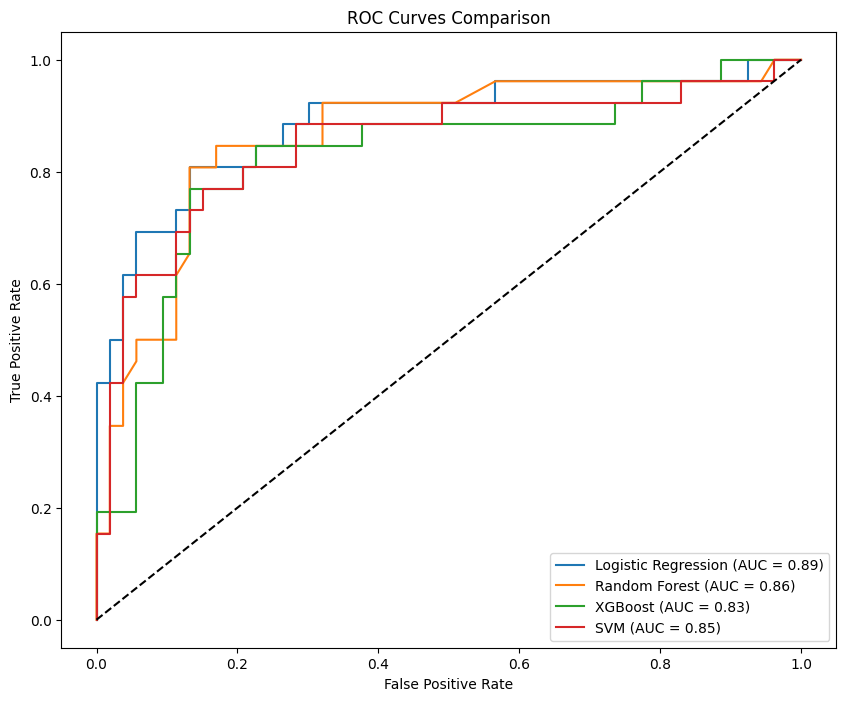

In [ ]:
# Cell 7: Model comparison (Corrected)
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Load processed data
X_train = pd.read_csv("data/processed/X_train.csv")
X_test = pd.read_csv("data/processed/X_test.csv")
y_train = pd.read_csv("data/processed/y_train.csv").squeeze()
y_test = pd.read_csv("data/processed/y_test.csv").squeeze()

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(),
    "SVM": SVC(probability=True)
}

# Train and evaluate models
results = []
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Save results
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    })

    # Save model
    joblib.dump(model, f"models/{name.replace(' ', '_').lower()}.pkl")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.savefig(f'models/{name.replace(" ", "_").lower()}_cm.png')
    plt.show()

# Display results
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
display(results_df)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.savefig('models/roc_curves.png')
plt.show()

In [ ]:
# Cell 8: Install SHAP for model interpretation
!pip install shap

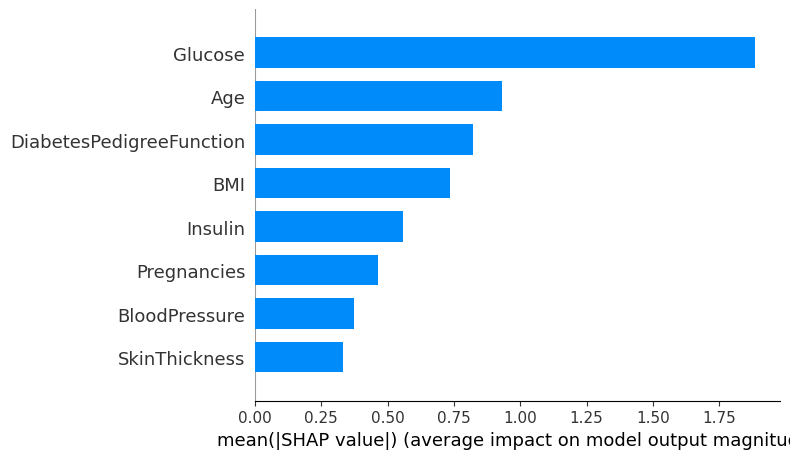

<Figure size 640x480 with 0 Axes>

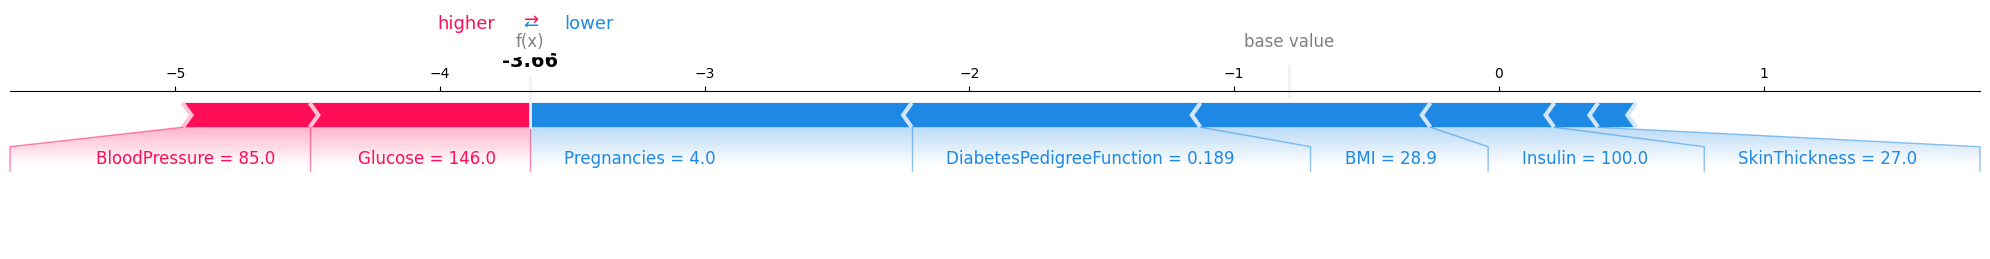

In [ ]:
# Cell 9: Model Interpretation with SHAP
import shap

# Load best model (XGBoost is usually best)
best_model = joblib.load("models/xgboost.pkl")

# Explain model predictions
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.savefig('models/feature_importance.png')
plt.show()

# Individual prediction explanation
sample_idx = 0  # First sample in training set
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    X_train.iloc[sample_idx],
    matplotlib=True,
    show=False
)
plt.tight_layout()
plt.savefig('models/individual_shap.png')
plt.show()

In [ ]:
# Cell 10: Generate performance report
with open('models/performance_report.md', 'w') as f:
    f.write("# Model Performance Report\n\n")
    f.write(results_df.to_markdown(index=False) + "\n\n")

    # Find best model by ROC AUC
    best_model_name = results_df.sort_values('ROC AUC', ascending=False).iloc[0]['Model']
    best_row = results_df[results_df['Model'] == best_model_name].iloc[0]

    f.write(f"## Best Model: {best_model_name}\n")
    f.write(f"- Accuracy: {best_row['Accuracy']:.4f}\n")
    f.write(f"- F1 Score: {best_row['F1 Score']:.4f}\n")
    f.write(f"- ROC AUC: {best_row['ROC AUC']:.4f}\n\n")

    f.write("## Confusion Matrix\n")
    f.write(f"![Confusion Matrix](models/{best_model_name.replace(' ', '_').lower()}_cm.png)\n\n")

    f.write("## ROC Curves\n")
    f.write("![ROC Curves](models/roc_curves.png)\n\n")

    f.write("## Feature Importance\n")
    f.write("![Feature Importance](models/feature_importance.png)\n")

print("Report saved to models/performance_report.md")

Report saved to models/performance_report.md


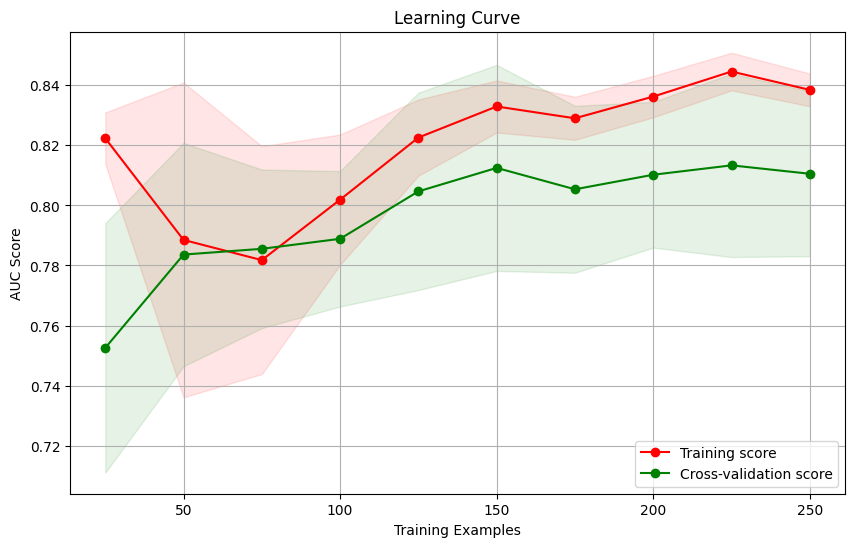

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring='roc_auc',
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calculate means and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_mean - val_std,
                     val_mean + val_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_mean, 'o-', color="g", label="Cross-validation score")

    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("AUC Score")
    plt.legend(loc="best")
    plt.grid()
    plt.savefig('models/learning_curve.png')
    plt.show()

# Usage
plot_learning_curve(model, X_train, y_train)